In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
from tqdm import tqdm, trange

In [2]:
%cd ..

/n/home10/rdeshpande/morphogenesis/jax-morph


In [3]:
import jax
import jax.numpy as np
import jax.tree_util as jtu

key = jax.random.PRNGKey(1)

jax.config.update("jax_debug_nans", True)
jax.config.update("jax_enable_x64", True)

import jax_md
import equinox as eqx

import jax_morph as jxm
from jax_morph.visualization import draw_circles_divrate, draw_circles_chem, draw_circles_stress, draw_circles_ctype

import matplotlib.pyplot as plt

# Cell State

In [43]:
#all new cell states must inherit from jxm.BaseCellState
class CellState(jxm.BaseCellState):
    chemical:           jax.Array
    secretion_rate:     jax.Array
    chemical_grad:      jax.Array
    hidden_state:       jax.Array

In [44]:
N_DIM = 2
N_CHEM = 16
N_HIDDEN = 32
N_CTYPES = 2
N_INIT = 20
N = 120
N_ADD_INIT = N_INIT - 1
N_ADD = N - N_INIT


### Build initial state

disp, shift = jax_md.space.free()

istate = CellState(
    displacement=   disp,
    shift=          shift,
    position=       np.zeros(shape=(N,N_DIM)),
    celltype=       np.zeros(shape=(N,N_CTYPES)).at[0].set([0.0, 1.0]),
    radius=         np.zeros(shape=(N,1)).at[0].set(.5),
    division=       np.zeros(shape=(N,1)).at[0].set(1.),
    chemical=       np.zeros(shape=(N,N_CHEM)),
    chemical_grad=  np.zeros(shape=(N,int(N_DIM*N_CHEM))),
    secretion_rate= np.zeros(shape=(N,N_CHEM)).at[0].set(1.),
    hidden_state=   np.zeros(shape=(N,N_HIDDEN))
)

In [45]:
key, init_key = jax.random.split(key)
mech_potential = jxm.env.mechanics.MorsePotential(epsilon=3., alpha=2.8)
init_model = jxm.Sequential(
    substeps=[
        jxm.env.CellDivision(),
        jxm.env.CellGrowth(growth_rate=.03, max_radius=.5, growth_type='linear'),
        jxm.env.mechanics.SGDMechanicalRelaxation(mech_potential),    
    ])

In [46]:
key, subkey = jax.random.split(key)
init_state, _ = jxm.simulate(init_model, istate, subkey, N_ADD_INIT)

In [47]:
# Assign an initial imbalance in celltypes
ctype = init_state.celltype
ctype = ctype.at[:int(.35*N_INIT), 0].set(1.0)
ctype = ctype.at[:int(.35*N_INIT), 1].set(0.0)
init_state = eqx.tree_at(lambda s: s.celltype, init_state, ctype)

In [48]:
init_state

CellState(
  displacement=<function displacement_fn>,
  shift=<function shift_fn>,
  position=f64[120,2],
  celltype=f64[120,2],
  radius=f64[120,1],
  division=f64[120,1],
  chemical=f64[120,16],
  secretion_rate=f64[120,16],
  chemical_grad=f64[120,32],
  hidden_state=f64[120,32]
)

# Model

**NOTE 1:** Every parameter that is passed as a jax array will be differentiated over and subject to optimization. Every parameter that is passed as a python primitive will be treated as a constant.

**NOTE 2:** There is currently no (easy) way to do the opposite in jax-morph, that is to choose *not* to differentiate w.r.t. a jax array. It is possible in principle but doesn't look like we used this feature that much until now, so its introduction is postponed.

In [49]:
class SecretionMaskCellType(jxm.SimulationStep):
    ctype_sec_chem:     eqx.field(static=True)

    def return_logprob(self) -> bool:
        return False

    def __init__(self, state, ctype_sec_chem=None):

        if ctype_sec_chem is None:
            self.ctype_sec_chem = np.repeat(np.atleast_2d([1.]*state.chemical.shape[1]), state.celltype.shape[-1], axis=0).tolist()

        else:

            if np.asarray(ctype_sec_chem).shape != (state.celltype.shape[1], state.chemical.shape[1]):
                raise ValueError("ctype_sec_chem must be shape (N_CELLTYPE, N_CHEM)")
            
            self.ctype_sec_chem = ctype_sec_chem
        
        
    @jax.named_scope("jax_morph.SecretionByCellType")
    def __call__(self, state, *, key=None, **kwargs):
            
        sec_mask = state.celltype @ np.atleast_2d(self.ctype_sec_chem)

        secretion_rate = sec_mask*state.secretion_rate

        state = eqx.tree_at(lambda s: s.secretion_rate, state, secretion_rate)

        return state

In [50]:
ctype_sec_chem = np.zeros((N_CTYPES, N_CHEM))
ctype_sec_chem = ctype_sec_chem.at[0, :int(N_CHEM/2)].set(1.0)
ctype_sec_chem = ctype_sec_chem.at[1, int(N_CHEM/2):].set(1.0)

In [51]:
key, init_key = jax.random.split(key)


mech_potential = jxm.env.mechanics.MorsePotential(epsilon=3., alpha=2.8)

model = jxm.Sequential(
    substeps=[
        jxm.env.CellDivision(),
        jxm.env.CellGrowth(growth_rate=.03, max_radius=.5, growth_type='linear'),
        jxm.env.mechanics.SGDMechanicalRelaxation(mech_potential),
        #jxm.env.SteadyStateDiffusion(degradation_rate=.8, diffusion_coeff=.5), #WORKS LESS WELL, BUT STILL WORKS -- ???
        jxm.env.diffusion.ApproxSteadyStateDiffusion(degradation_rate=.8, diffusion_coeff=.5),
        jxm.cell.sensing.LocalChemicalGradients(),
        jxm.cell.GeneNetwork(init_state,
                            input_fields=['chemical', 'chemical_grad', 'division', 'radius'],
                            output_fields=['secretion_rate', 'division'],
                            key=init_key,
                            transform_output={'division': lambda s,x: x*jax.nn.sigmoid(50*(s.radius - .45))},
                            expr_level_decay=1.,
                            interaction_init=jax.nn.initializers.normal(0.1)
                            ), 
       jxm.cell.SecretionMaskByCellType(init_state, ctype_sec_chem.tolist()),
    ])

# REINFORCE Loss

In [52]:
from functools import partial

In [53]:
@eqx.filter_jit
def reinforce_loss(model, istate, *, cost_fn, key, n_steps=1, BATCH_SIZE=1, GAMMA=.9, LAMBDA=.001):

    subkeys = jax.random.split(key, BATCH_SIZE)
    subkeys = np.asarray(subkeys)

    vsim = jax.vmap(partial(jxm.simulate, history=True), (None, None, 0, None))
    trajectory, logp = vsim(model, istate, subkeys, n_steps)


    istate = jtu.tree_map(lambda x: np.repeat(x[None,None,:,:],BATCH_SIZE,0), istate)

    trajectory = jtu.tree_map(lambda *v: np.concatenate(v,1), *[istate, trajectory])


    cost = jax.vmap(cost_fn)(trajectory)


    #discounted costs
    def _returns_rec(rewards):
        Gs=[]
        G=0
        for r in rewards[::-1]:
            G = r+G*GAMMA
            Gs.append(G)

        return np.array(Gs)[::-1]
    
    
    cost = jax.vmap(_returns_rec)(cost)

    cost = (cost-cost.mean(-1, keepdims=True))/(cost.std(-1, keepdims=True)+1e-8)


    #no - sign because we assume a cost instead of a reward
    loss = np.sum(jax.lax.stop_gradient(cost)*logp)


    #L1 penalty on weights
    reg = jax.tree_map(lambda x: np.abs(x).sum(), eqx.filter(model, eqx.is_array))
    reg = jax.tree_util.tree_reduce(lambda x,y: x+y, reg)

    return loss + LAMBDA*reg

## Cost Functions

In [54]:
key, subkey = jax.random.split(key)
s, _ = jxm.simulate(model, init_state, subkey, N_ADD)
ss, _ = jxm.simulate(model, init_state, subkey, N_ADD, history=True)

(<Figure size 800x800 with 1 Axes>, <Axes: >)

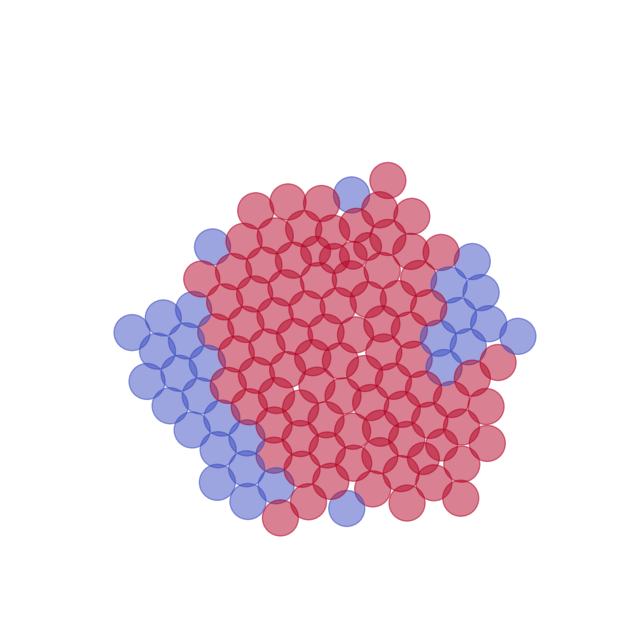

In [55]:
draw_circles_ctype(s)

In [56]:
COST_FN = jxm.opt.cost_functions.CellTypeImbalance(metric='entropy')
COST_FN(ss)[-1]

Array(0.03312805, dtype=float64)

# Training

In [57]:
import optax
from tqdm import trange
from functools import partial

In [52]:
EPOCHS = 150
BATCH_SIZE = 4


COST_FN = jxm.opt.cost_functions.CellTypeImbalance(metric="entropy")
LAMBDA=0.1


opt_model = model


optimizer = optax.adam(1e-3)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

key, subkey = jax.random.split(key)

rl, g = eqx.filter_value_and_grad(reinforce_loss)(opt_model, init_state, cost_fn=COST_FN, key=subkey, n_steps=N_ADD, BATCH_SIZE=BATCH_SIZE, LAMBDA=LAMBDA, GAMMA=.90)

l = COST_FN(jxm.simulate(opt_model, init_state, subkey, N_ADD, history=True)[0]).sum()


rlosses = [float(rl)]
losses = [float(l)]

pbar = trange(EPOCHS)
for e in pbar:

    try:
        # g = jax.tree_map(lambda x: x/(np.linalg.norm(x)+1e-10), g)

        updates, opt_state = optimizer.update(g, opt_state, opt_model)
        opt_model = eqx.apply_updates(opt_model, updates)

        key, subkey = jax.random.split(key)

        rl, g = eqx.filter_value_and_grad(reinforce_loss)(opt_model, init_state, cost_fn=COST_FN, key=subkey, n_steps=N_ADD, BATCH_SIZE=BATCH_SIZE, LAMBDA=LAMBDA, GAMMA=.90)

        l = COST_FN(jxm.simulate(opt_model, init_state, subkey, N_ADD, history=True)[0]).sum()


        rlosses.append(float(rl))
        losses.append(float(l))
        pbar.set_description(f'Loss: {l:.3f}')

    except FloatingPointError:
        print('NaN or Overflow')
        break

    except KeyboardInterrupt:
        print('Interrupted')
        break

Loss: -2.812: 100%|██████████████████████████████████████████████████████████████████████| 250/250 [15:53<00:00,  3.81s/it]


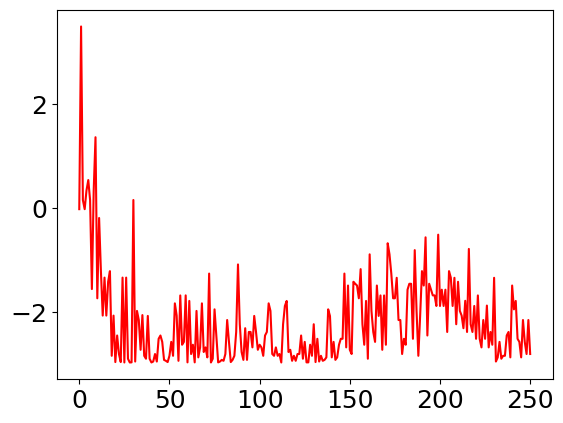

In [53]:
plt.plot(losses, 'r');

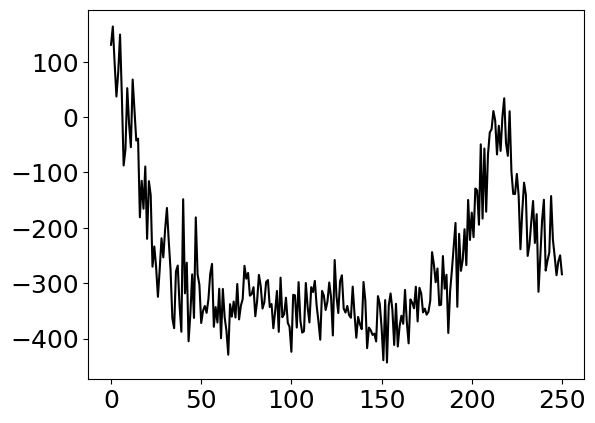

In [54]:
plt.plot(rlosses, 'k');

In [55]:
def _final_cost_distribution(model, istate, subkeys, n_sim_steps):
    vsim = jax.vmap(jxm.simulate, (None, None, 0, None))
    s, _ = vsim(model, istate, subkeys, n_sim_steps)
    p = s.celltype.sum(0)/s.celltype.sum(0).sum(-1, keepdims=True)
    rel_entropy = -(p*np.log(p+1e-8)).sum(-1)/np.log(p.shape[-1])
    cost = 1 - rel_entropy
    return cost

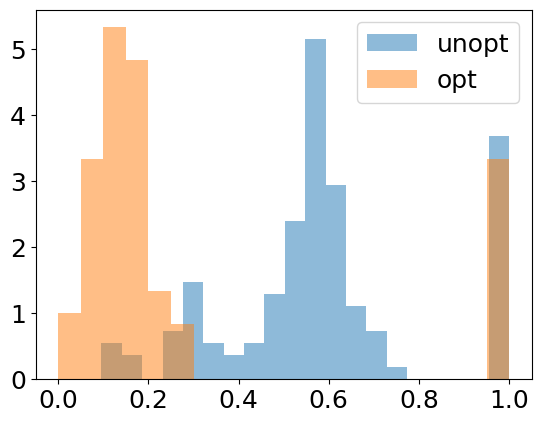

In [56]:
subkeys = np.asarray(jax.random.split(key, 300))

mcost = _final_cost_distribution(model, init_state, subkeys, N_ADD)
ocost = _final_cost_distribution(opt_model, init_state, subkeys, N_ADD)

plt.hist(mcost, bins=20, alpha=.5, density=True, label="unopt")
plt.hist(ocost, bins=20, alpha=.5, density=True, label="opt");
plt.legend();

In [57]:
key, subkey = jax.random.split(key)
s, _ = jxm.simulate(opt_model, init_state, subkey, N_ADD)

print(s.celltype.sum(0) @ np.asarray([1.,-1.]))

52.0


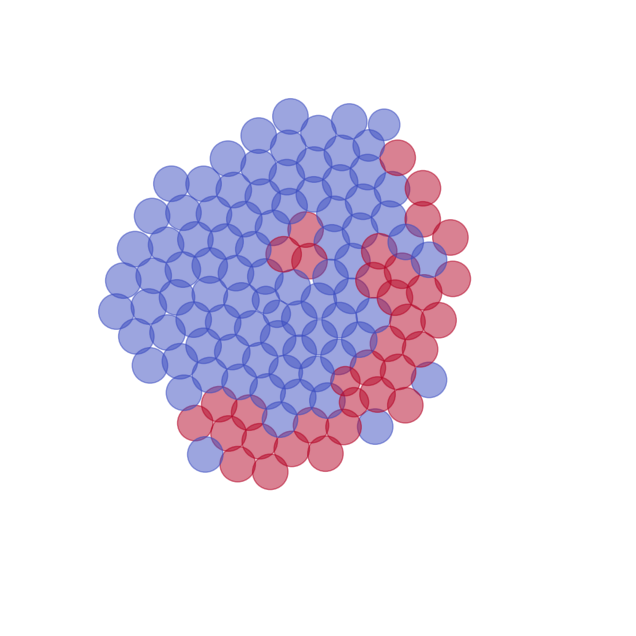

In [58]:
draw_circles_ctype(s);

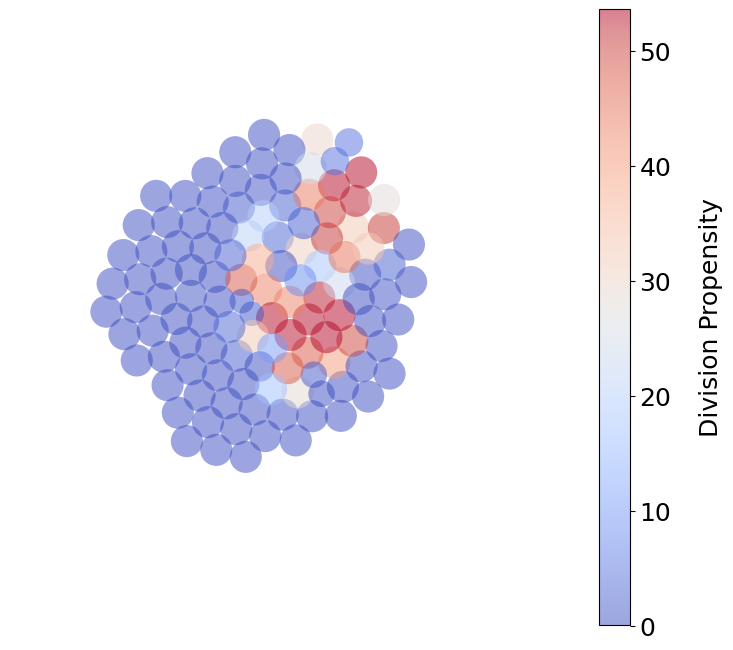

In [59]:
draw_circles_divrate(s);

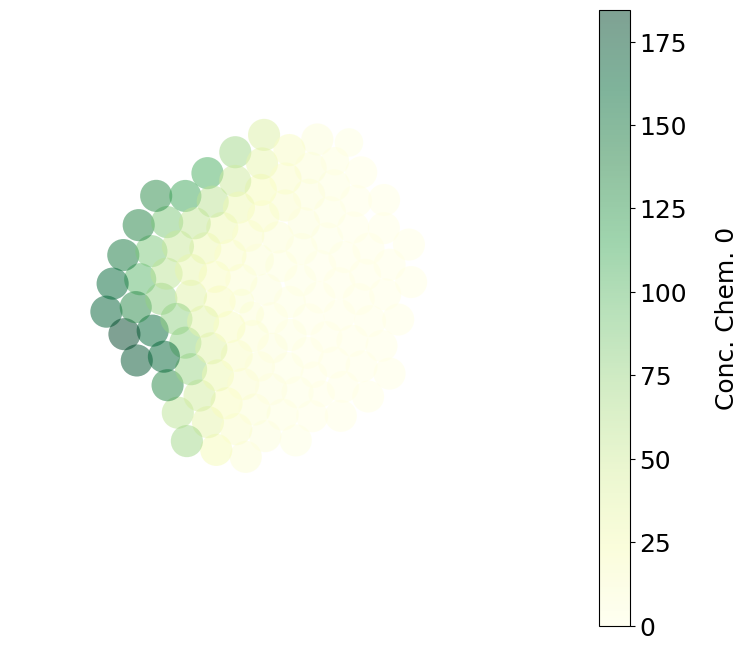

In [60]:
draw_circles_chem(s, 0);

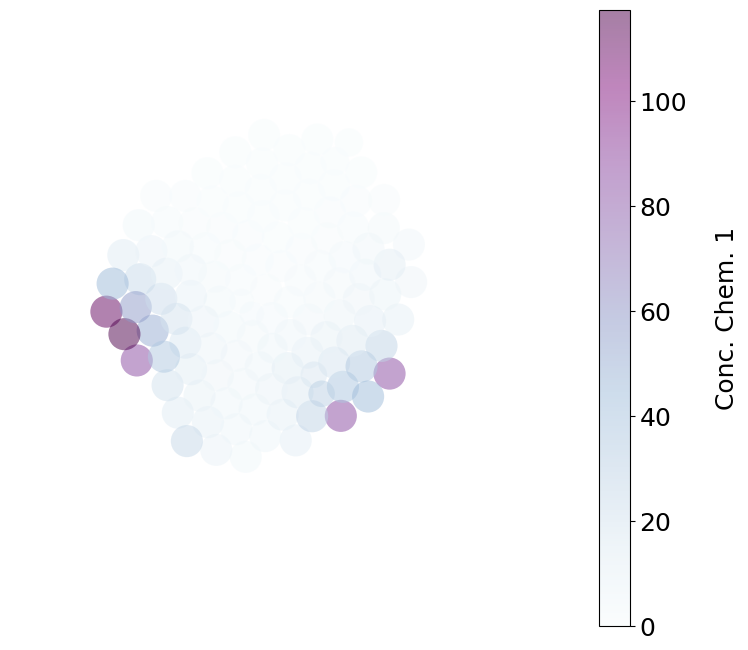

In [61]:
draw_circles_chem(s, 1);

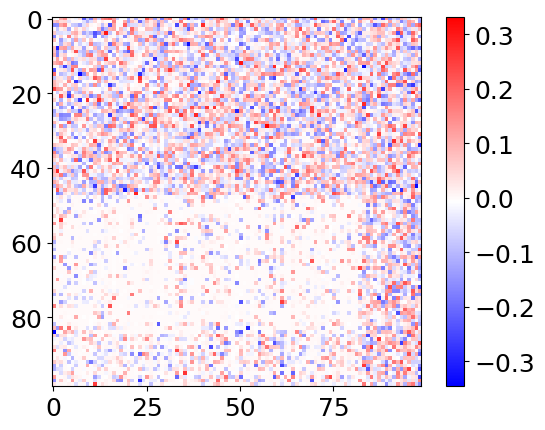

In [62]:
plt.imshow(opt_model[-2].interaction_matrix, cmap='bwr')
plt.colorbar();

100%|██████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:37<00:00,  1.26s/it]


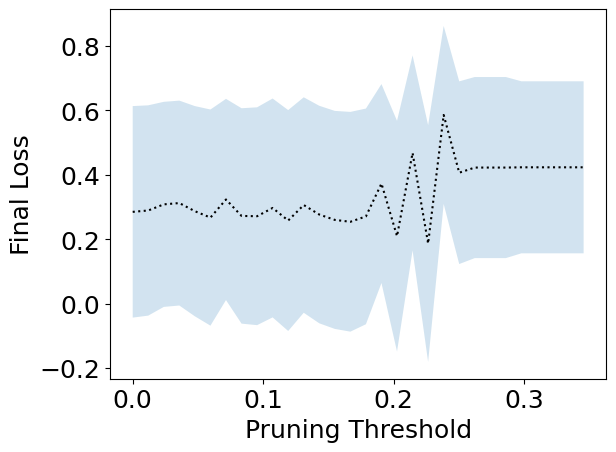

In [71]:
interact_mat = opt_model[-2].interaction_matrix
thrs = np.linspace(0., np.abs(interact_mat).max(), 30)
subkeys = np.asarray(jax.random.split(key, 100))

cc = []
for thr in tqdm(thrs):
    pm = eqx.tree_at(lambda m: m[-2].interaction_matrix, opt_model, np.where(np.abs(interact_mat)<thr, 0., interact_mat))
    cc += [_final_cost_distribution(pm, init_state, subkeys, N_ADD)]


plt.plot(thrs, np.asarray(cc).mean(-1).tolist(), 'k:')
plt.fill_between(thrs, (np.asarray(cc).mean(-1) - np.asarray(cc).std(-1)).tolist(), (np.asarray(cc).mean(-1) + np.asarray(cc).std(-1)).tolist(), alpha=.2)

plt.xlabel('Pruning Threshold')
plt.ylabel('Final Loss');

In [66]:
W = opt_model[-2].interaction_matrix
NUM_IN = N_CHEM + N_CHEM*2 + 2
NUM_OUT = N_CHEM + 1
node_colors = ["violet"]*NUM_IN + ["limegreen"]*N_HIDDEN + ["blue"] + ["darkorange"]*(NUM_OUT - 1)
node_sizes = [100]*NUM_IN + [30]*N_HIDDEN + [100]*NUM_OUT

/n/home10/rdeshpande/.conda/envs/jax_new_code/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:305: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for connectionstyle.
Note that using FancyArrowPatches may be slow for large graphs.

  draw_networkx_edges(G, pos, arrows=arrows, **edge_kwds)


Text(0.5, 1.0, 'Gene network')

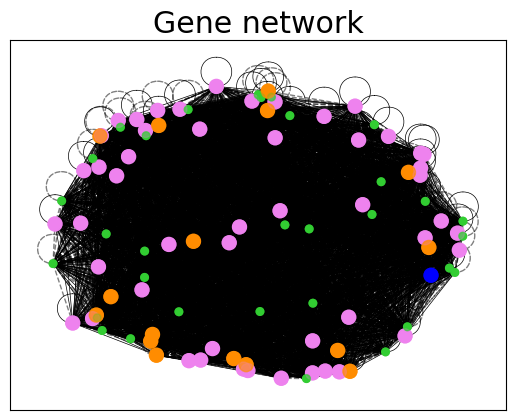

In [67]:
# Visualize network
import networkx as nx
G = nx.from_numpy_array(W)
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, connectionstyle="arc3,rad=0.1", edgelist=[(v, u) for u,v,w in G.edges(data=True) if w['weight']>0], with_labels=False, node_size=node_sizes, width=.5, alpha=1., node_color=node_colors)
nx.draw_networkx(G, pos, connectionstyle="arc3,rad=0.1", style='--', edgelist=[(v, u) for u,v,w in G.edges(data=True) if w['weight']<0], with_labels=False, node_size=node_sizes, width=1., alpha=.5, node_color=node_colors)
plt.title("Gene network")